# Walmart Sales Forecast Models

Provide weekly sales forecast by developing the following models:
- ARIMA
- SARIMAX

The data used for developing the models is prepared by the [data wrangling program](https://github.com/nphan20181/walmart_sales/blob/master/walmart_data_wrangling.ipynb).

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa import stattools
import warnings
from pmdarima.arima import auto_arima
%matplotlib inline

sns.set()
#plt.style.use('seaborn-dark')
warnings.filterwarnings("ignore")
mpl.rcParams['axes.titlesize'] = 17    # font size for plot title
mpl.rcParams['axes.labelsize'] = 14    # font size for x-axis' and y-axis' label

In [2]:
def forecast_accuracy(forecast, actual):
    '''
    Compute metrics for model's evaluation.
    
    Parameters:
    - forecast: predicted values
    - actual: observed values
    
    Return a data frame of metrics.
    '''
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # Mean Absolute Percentage Error (MAPE)
    me = np.mean(forecast - actual)                           # Mean Error (ME)
    mae = np.mean(np.abs(forecast - actual))                  # Mean Absolute Error (MAE)
    mpe = np.mean((forecast - actual)/actual)                 # Mean Percentage Error (MPE)
    mse = np.mean((forecast - actual)**2)                     # Mean Squared Error (MSE)
    rmse = np.mean((forecast - actual)**2)**.5                # Root Mean Squared Error (RMSE)
    corr = np.corrcoef(forecast, actual)[0,1]                 # correlation
    
    # compute min-max
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)
    
    return(pd.DataFrame({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'mse': mse, 'rmse':rmse,  
            'corr':corr, 'minmax':minmax}, index=[0]))

In [3]:
# load data
weekly_sales = pd.read_pickle('out/weekly_sales.pkl')
weekly_sales.index = weekly_sales['Date']
sales = weekly_sales['Weekly Sales (Million)']

In [4]:
weekly_sales.head()

,Date,IsHoliday,Week,Month,Quarter,Year,Weekly Sales (Million)
Date,,,,,,,
2010-01-08,2010-01-08,False,1,1,1,2010,43.865605
2010-01-15,2010-01-15,False,2,1,1,2010,41.348378
2010-01-22,2010-01-22,False,3,1,1,2010,41.367822
2010-01-29,2010-01-29,False,4,1,1,2010,39.717414
2010-02-05,2010-02-05,False,5,2,1,2010,49.750740


## Autoregressive (AR) Terms

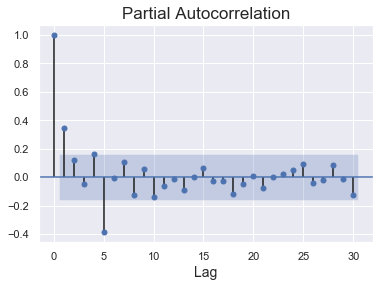

In [5]:
# use PACF plot to figure out the best order of the AR model
sm.graphics.tsa.plot_pacf(sales, lags=30)
plt.xlabel('Lag')
plt.show()

## Moving Average (MA) Terms

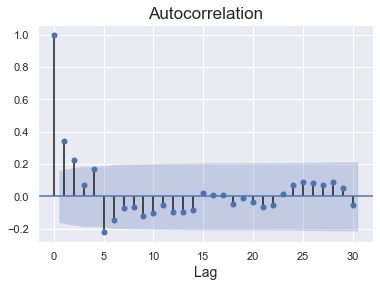

In [6]:
# use ACF plot to figure out the best order of the MA model
sm.graphics.tsa.plot_acf(sales, lags=30)
plt.xlabel('Lag')
plt.show()

## ARIMA Model

In [7]:
def ArimaModel(ar_orders, d_orders, ma_orders):
    '''
    Fit ARIMA model using various orders for AR, Differencing, and MA.
    Select the model that has lowest AIC score.
    Plot the orginal time series and forecast.
    
    Parameters:
    - ar_orders: a list of number of autoregressive terms (AR order)
    - d_orders: a list of number of nonseasonal differences (differencing order)
    - ma_orders: a list of number of moving-average terms (MA order)
    
    Return the model's fit result.
    '''
    
    global sales
    min_aic = 99999                # initialize minimum AIC to a very high number
    best_model = None
    best_p = best_d = best_q = 0   # initialize order for AR, Differencing, and MA to zero
    
    for p in ar_orders:
        for d in d_orders:
            for q in ma_orders:
                model = ARIMA(sales, order=(p, d, q))
                results = model.fit(disp=0)
                aic = results.aic
                
                # select model with lowest AIC score
                if aic < min_aic:
                    min_aic = aic
                    best_model = model
                    best_p = p            # AR order
                    best_d = d            # Differencing order
                    best_q = q            # MA order
    
    # fit the best model
    results = best_model.fit(disp=-1)
    
    # plot observed and forecasted values
    fig, ax = plt.subplots(figsize=(14,5))
    plt.plot(sales, label='Observe')                                # plot original time series
    plt.plot(results.fittedvalues, color='red', label='Forecast')   # plot predictions
    plt.legend(loc='best', frameon=False)
    plt.ylabel('Weekly Sales (Million USD)')
    plt.xlabel('Date')
    plt.title("Walmart's Weekly Sales")
    plt.show()
    
    return results

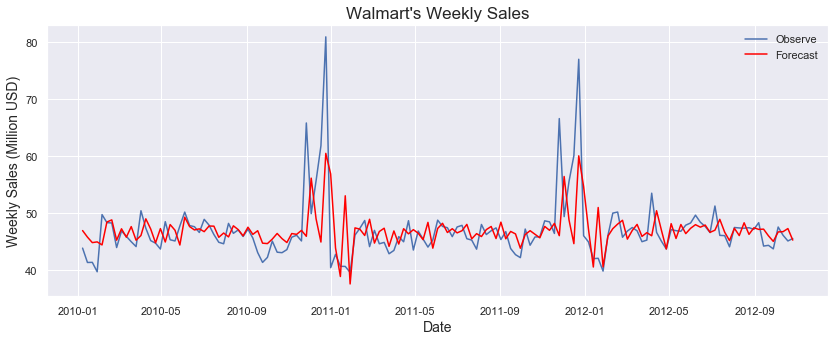

In [8]:
# since time series is stationary, the order for differencing is 0
model_fit = ArimaModel([1], [0], [1, 2])

In [9]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     Weekly Sales (Million)   No. Observations:                  147
Model:                         ARMA(1, 2)   Log Likelihood                -440.155
Method:                           css-mle   S.D. of innovations              4.819
Date:                    Wed, 22 Apr 2020   AIC                            890.310
Time:                            22:33:00   BIC                            905.262
Sample:                        01-08-2010   HQIC                           896.385
                             - 10-26-2012                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           46.9451      0.642     73.106      0.000      45.687      48.204
ar.L1.Weekly Sales (Million)    -0.7320      0.086     -8.509      0.000      -0.901      -0.563
ma.L1.Weekly Sales (Million)     1.2129      0.084     14.509      0.000       1.049       1.377
ma.L2.Weekly Sales (Million)     0.5935      0.087      6.837      0.000       0.423       0.764
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3662           +0.0000j            1.3662            0.5000
MA.1           -1.0219           -0.8005j            1.2981           -0.3942
MA.2           -1.0219           +0.8005j            1.2981            0.3942
-----------------------------------------------------------------------------
"""

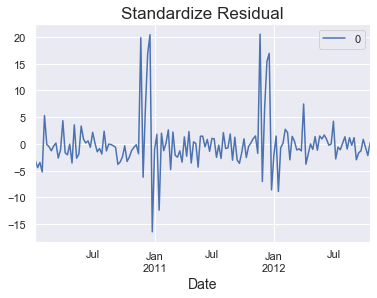

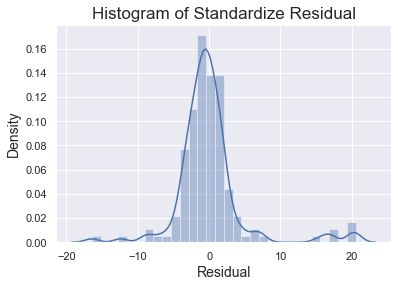

In [10]:
residuals = pd.DataFrame(model_fit.resid)

# plot standardize residuals
residuals.plot()
plt.title('Standardize Residual')
plt.xlabel('Date')
plt.show()

# plot histogram of residuals
sns.distplot(residuals, kde=True)
plt.title('Histogram of Standardize Residual')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.show()

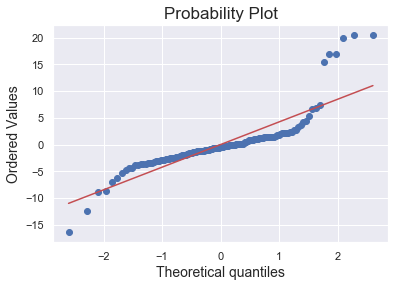

In [11]:
import pylab 
import scipy.stats as stats

# qq plot to check for normality
stats.probplot(residuals.reset_index()[0], dist="norm", plot=pylab)
pylab.show()

In [12]:
forecast_accuracy(model_fit.fittedvalues, sales)

,mape,me,mae,mpe,mse,rmse,corr,minmax
0,0.055867,-0.004523,2.789844,0.007588,23.296938,4.82669,0.463302,0.05262


Around 5.5% MAPE implies the model is about 94.5% accurate in predicting the next 15 observations

## ARIMA Model using stepwise

In [13]:
# fit ARIMA model using auto_arima
arima_model = auto_arima(sales, start_p=0, start_q=0,
                         max_p=1, max_q=2,
                         seasonal=False,
                         d=0, trace=True,
                         stepwise=True,
                         error_action='ignore',  
                         suppress_warnings=True)
arima_model.aic()

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=918.689, BIC=924.669, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=902.238, BIC=911.209, Time=0.042 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=907.251, BIC=916.223, Time=0.057 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1552.831, BIC=1555.822, Time=0.006 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=902.545, BIC=914.507, Time=0.205 seconds
Total fit time: 0.321 seconds


902.2381819977894

In [14]:
arima_model.fit(sales)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  147
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -448.119
Date:                Wed, 22 Apr 2020   AIC                            902.238
Time:                        22:33:01   BIC                            911.209
Sample:                             0   HQIC                           905.883
                                - 147                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     30.8147      2.333     13.208      0.000      26.242      35.387
ar.L1          0.3436      0.038      8.953      0.000       0.268       0.419
sigma2        26.0008      1.546     16.819      0.000      22.971      29.031
===================================================================================
Ljung-Box (Q):                       42.29   Jarque-Bera (JB):              1207.86
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               2.23   Skew:                             2.62
Prob(H) (two-sided):                  0.01   Kurtosis:                        16.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

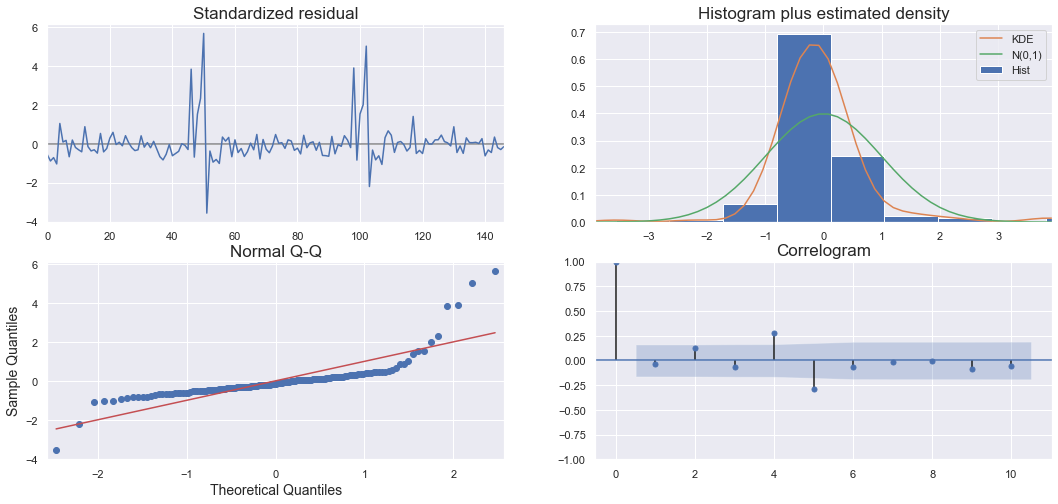

In [15]:
arima_model.plot_diagnostics(figsize=(18, 8))
plt.show()

In [16]:
# get predictions and compute metrics for model's evaluation
forecast_accuracy(arima_model.predict_in_sample(start=0, end=len(sales) - 1), sales)

,mape,me,mae,mpe,mse,rmse,corr,minmax
0,0.056297,-0.007828,2.830347,0.008702,26.008402,5.099843,0.34417,0.05323


## SARIMAX Model

In [17]:
# use auto_arima to select the best model for SARIMAX model
stepwise_model = auto_arima(sales, start_p=0, start_q=0,
                           max_p=1, max_q=2, m=52,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
stepwise_model.aic()

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 0, 1, 52) (constant=True); AIC=840.265, BIC=849.236, Time=1.300 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 52) (constant=True); AIC=918.689, BIC=924.669, Time=0.007 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 52) (constant=True); AIC=727.834, BIC=739.796, Time=3.712 seconds
Near non-invertible roots for order (1, 0, 0)(1, 0, 0, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 52) (constant=True); AIC=828.506, BIC=840.468, Time=1.997 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 52) (constant=False); AIC=1552.831, BIC=1555.822, Time=0.007 seconds
Fit ARIMA: (0, 0, 0)x(1, 0, 1, 52) (constant=True); AIC=759.219, BIC=771.181, Time=3.687 seconds
Near non-invertible roots for order (0, 0, 0)(1, 0, 1,

727.8339668083806

In [18]:
# fit the model
stepwise_model.fit(sales)

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 0, 0, 52),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [19]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  147
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 52)   Log Likelihood                -359.917
Date:                            Wed, 22 Apr 2020   AIC                            727.834
Time:                                    22:33:57   BIC                            739.796
Sample:                                         0   HQIC                           732.694
                                            - 147                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.6581      0.431      6.161      0.000       1.813       3.504
ar.L1          0.2734      0.052      5.254      0.000       0.171       0.375
ar.S.L52       0.9217      0.009     98.294      0.000       0.903       0.940
sigma2         3.9129      0.379     10.330      0.000       3.170       4.655
===================================================================================
Ljung-Box (Q):                       26.05   Jarque-Bera (JB):               610.89
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             1.71
Prob(H) (two-sided):                  0.10   Kurtosis:                        12.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

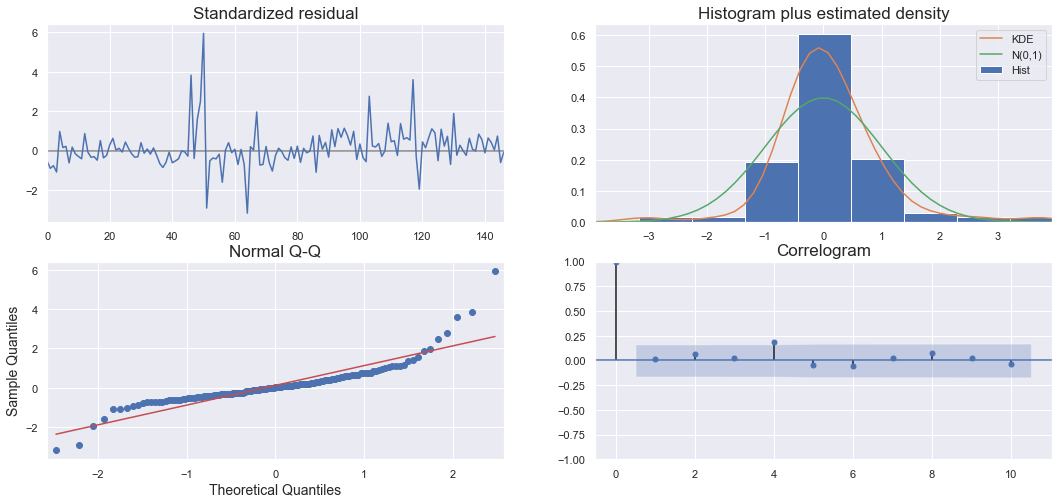

In [20]:
stepwise_model.plot_diagnostics(figsize=(18, 8))
plt.show()

In [21]:
# get predictions and compute metrics for model's evaluation
yhat = stepwise_model.predict_in_sample(start=0, end=len(sales) - 1)
forecast_accuracy(yhat, sales)

,mape,me,mae,mpe,mse,rmse,corr,minmax
0,0.039452,-0.32611,1.964519,-0.001927,15.520546,3.939612,0.691568,0.037862


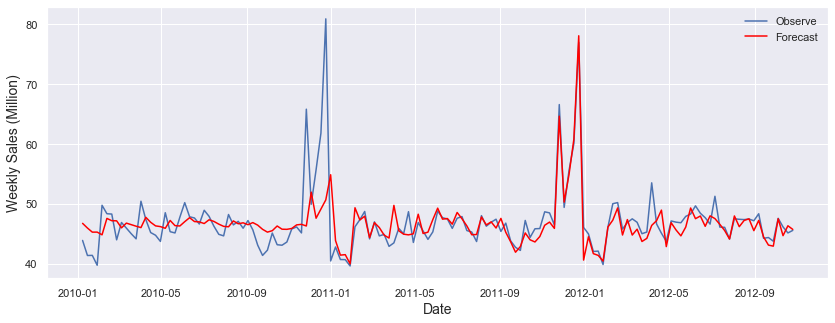

In [22]:
'''Plot original time series and forecast'''
fig, ax = plt.subplots(figsize=(14,5))

predicts = pd.DataFrame(yhat)
predicts.index = sales.index

plt.plot(sales, label='Observe')
plt.plot(predicts, color='red', label='Forecast')

plt.legend(loc='best', frameon=False)
plt.ylabel('Weekly Sales (Million)')
plt.xlabel('Date')
plt.show()

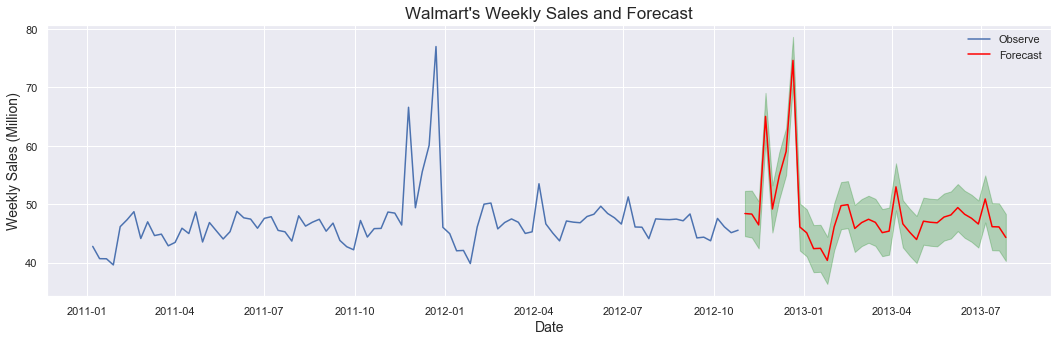

In [23]:
'''Plot original time series and forecast for the next 39 weeks'''

# get date for the next 39 time series index
forecast_index = pd.read_csv('data/ts_forecast.csv', header=None).rename(columns={0:'Date'})

# get forecast and confident intervals for the next 39 weeks
forecast, forecast_ci = stepwise_model.predict(39, return_conf_int=True, alpha=0.05)
sales_forecast = pd.DataFrame({'Weekly Sales (Million)': forecast, 
                               'Lower': forecast_ci[:,0],
                               'Upper': forecast_ci[:,1]}, index=pd.to_datetime(forecast_index['Date']))

# create figure
fig, ax = plt.subplots(figsize=(18,5))

# plot original time series for sales from Nov 2010
plt.plot(sales[sales.index > pd.to_datetime('2010-12-31')], label='Observe')

# plot future sales forecast
plt.plot(sales_forecast['Weekly Sales (Million)'], label='Forecast', color='red')

# plot forecast's confident interval
ax.fill_between(sales_forecast.index,
                sales_forecast['Lower'],
                sales_forecast['Upper'], color='green', alpha=.25)

plt.legend(loc='best', frameon=False)
plt.ylabel('Weekly Sales (Million)')
plt.xlabel('Date')
plt.title("Walmart's Weekly Sales and Forecast")
plt.show()